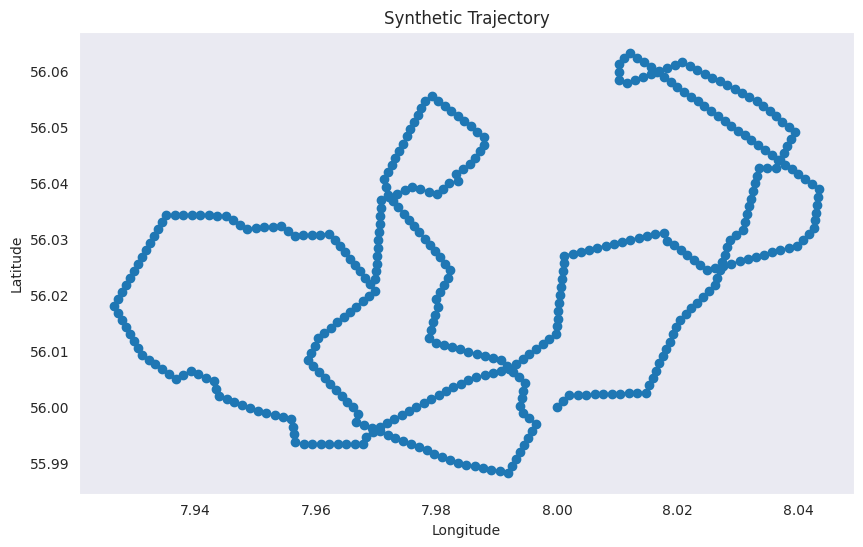

In [13]:
from typing import List, Tuple

import matplotlib.pyplot as plt
import random, math

class SyntheticTrajectoryGenerator:
    def __init__(
            self,
            start_lat: float = 56.0,
            start_lng: float = 8.0,
            start_timestamp: int = None,
            step_seconds: int = 60,
            num_points: int = 20,
            delta_lat: float = 0.001,
            delta_lng: float = 0.001,
            noise: float = 0.0,
            jitter_time: bool = False,
            seed: int = None,
    ):
        if seed is not None:
            random.seed(seed)
        self.start_lat = start_lat
        self.start_lng = start_lng
        self.step_seconds = step_seconds
        self.num_points = num_points
        self.delta_lat = delta_lat
        self.delta_lng = delta_lng
        self.noise = noise
        self.jitter_time = jitter_time

        if start_timestamp is None:
            import datetime

            start_timestamp = int(
                datetime.datetime.now(datetime.timezone.utc).timestamp()
            )
        self.start_timestamp = start_timestamp

    def generate(self) -> List[Tuple[float, float, int]]:
        lat, lng = self.start_lat, self.start_lng
        timestamp = self.start_timestamp

        trajectory = []

        num_turns = random.randint(1, self.num_points // 5)

        turning_points = sorted(random.sample(range(2, self.num_points - 2), num_turns))

        delta_lat = self.delta_lat
        delta_lng = self.delta_lng

        for i in range(self.num_points):
            # Apply turning point by changing direction randomly
            if i in turning_points:
                angle = random.uniform(-1.5, 1.5)  # radians
                cos_a = math.cos(angle)
                sin_a = math.sin(angle)
                new_delta_lat = cos_a * delta_lat - sin_a * delta_lng
                new_delta_lng = sin_a * delta_lat + cos_a * delta_lng
                delta_lat, delta_lng = new_delta_lat, new_delta_lng

            # Add noise and jitter
            noise_lat = random.uniform(-self.noise, self.noise)
            noise_lng = random.uniform(-self.noise, self.noise)
            time_offset = random.randint(-5, 5) if self.jitter_time else 0

            trajectory.append(
                (lng + noise_lng, lat + noise_lat, timestamp + time_offset)
            )

            lat += delta_lat
            lng += delta_lng
            timestamp += self.step_seconds

        return trajectory


generator = SyntheticTrajectoryGenerator(
    start_lat=56.0,
    start_lng=8.0,
    start_timestamp=None,
    step_seconds=60,
    num_points=400,
    delta_lat=0.001,
    delta_lng=0.001,
    noise=0.0,
    jitter_time=False,
    seed=None
)

trajectory = generator.generate()
plt.figure(figsize=(10, 6))
lngs, lats, timestamps = zip(*trajectory)
plt.plot(lngs, lats, marker='o')
plt.title("Synthetic Trajectory")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.show()



In [14]:


Trajectory = List[Tuple[float, float, int]]  # (longitude, latitude, timestamp in seconds)

import utm
from typing import List, Tuple
from torch.utils.data import Dataset

from new.encoder import (
    trajectory_to_time_annotated_utm_trajectory,
    time_annotated_utm_trajectory_to_trajectory
)

Trajectory = List[Tuple[float, float, int]]  # (longitude, latitude, timestamp in seconds)


class TrajectoryDataset(Dataset):
    def __init__(self, trajectories: List[Trajectory], max_length: int, stride: int):
        self.max_length = max_length
        self.stride = stride

        # Compute UTM conversion parameters based on the first trajectory
        self.center_lat = sum(lat for _, lat, _ in trajectories[0]) / len(trajectories[0])
        self.center_lng = sum(lng for lng, _, _ in trajectories[0]) / len(trajectories[0])
        _, _, self.zone_number, self.zone_letter = utm.from_latlon(self.center_lat, self.center_lng)

        # Create a list of (subtrajectory, full original trajectory index)
        self.windows = []

        for i, traj in tqdm(enumerate(trajectories)):
            utm_traj = trajectory_to_time_annotated_utm_trajectory(
                traj, self.center_lat, self.center_lng, self.zone_number, self.zone_letter
            )
            for start in range(0, len(utm_traj) - self.max_length + 1, self.stride):
                subtraj = utm_traj[start: start + self.max_length]
                self.windows.append(subtraj)

    def decode(self, tensor):
        return time_annotated_utm_trajectory_to_trajectory(
            tensor, self.center_lat, self.center_lng, self.zone_number, self.zone_letter
        )

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        traj = self.windows[idx]  # List[Tuple[float, float, int]]

        # Convert traj to tensor: shape (max_length, 3)
        # Each element: (easting, northing, timestamp)
        traj_tensor = torch.tensor(traj, dtype=torch.float32)

        # Return input and target (autoencoder style)
        return traj_tensor, traj_tensor

In [ ]:

import torch
from tqdm import tqdm
dataset = TrajectoryDataset(
    [
        generator.generate()  # Generate synthetic trajectory
        for _ in tqdm(range(10000))  # Generate 100 synthetic trajectories
    ]

    , max_length=160, stride=120)  # allow small overlap

print(dataset[0][0])
# We decode the first trajectory to make sure it corresponds to the original synthetic trajectory
traj = dataset.decode(dataset[0][0])
plt.figure(figsize=(10, 6))
lngs, lats, timestamps = zip(*traj)
plt.plot(lngs, lats, marker='o')
plt.title("Decoded Trajectory")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.show()



100%|██████████| 10000/10000 [00:02<00:00, 4010.26it/s]
1873it [00:15, 128.19it/s]

In [57]:
import torch
from torch import nn

# Check and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

input_dimension = 6  # (easting, northing, timestamp)
embedding_dim = 64
epochs = 10000



# Define encoder and decoder

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(input_dimension, embedding_dim)
        self.decoder = nn.Linear(embedding_dim, input_dimension)

    def forward(self, x):
        z = self.encoder(x)  # (B, T, embedding_dim)
        out = self.decoder(z)  # (B, T, input_dimension)
        return out


# Instantiate model and move to device
model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

model.train()

for epoch in range(epochs):
    total_loss = 0
    for i, (inputs, targets) in enumerate(data_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        reconstructed = model(inputs)
        loss = criterion(reconstructed, targets)
        loss.backward()

        if i % 10 == 0:
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 1} - Loss: {avg_loss:.6f}")


Using device: cuda


KeyboardInterrupt: 

[(-1.9657227993011475, 3.9744162559509277, 0.6648926734924316, 0.39124611020088196, 0.8136821985244751, -0.0006798207759857178), (-1.9497287273406982, 4.0020318031311035, 0.6648872494697571, 0.39124631881713867, 0.8306319713592529, 0.01599186658859253), (-1.9337353706359863, 4.0296478271484375, 0.6648820638656616, 0.39124637842178345, 0.8475818634033203, 0.032663702964782715), (-1.9177427291870117, 4.0572638511657715, 0.6648768782615662, 0.3912467360496521, 0.8645315170288086, 0.04933544993400574), (-1.9017510414123535, 4.084880352020264, 0.6648714542388916, 0.3912467360496521, 0.8814812898635864, 0.06600725650787354), (-1.885759949684143, 4.1124958992004395, 0.6648662090301514, 0.3912469744682312, 0.8984311819076538, 0.08267894387245178), (-1.8697699308395386, 4.14011287689209, 0.6648610830307007, 0.3912471532821655, 0.9153810739517212, 0.09935067594051361), (-1.853780746459961, 4.16772985458374, 0.6648557782173157, 0.3912472724914551, 0.932330846786499, 0.11602246761322021), (-1.8377

/tmp/ipykernel_9368/115679571.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  traj_tensor = torch.tensor(traj, dtype=torch.float32)
/tmp/ipykernel_9368/2337862689.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_batch = torch.tensor(input_tensor, dtype=torch.float32).unsqueeze(0).to(device)


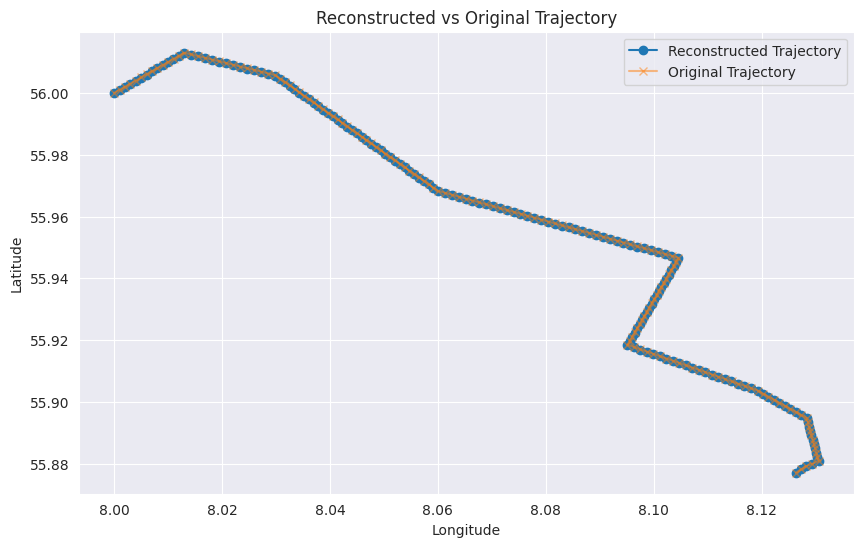

In [16]:
from torch import Tensor

# Put model in eval mode
model.eval()

# Get first input from dataset
input_tensor, _ = dataset[0]  # shape: (T, input_dim)

# Add batch dimension and convert to float tensor
input_batch = torch.tensor(input_tensor, dtype=torch.float32).unsqueeze(0).to(device)

# Forward pass through model (no grad needed)
with torch.no_grad():
    reconstructed = model(input_batch)  # shape (1, T, input_dim)

# Remove batch dim and convert to list of tuples
reconstructed = reconstructed.squeeze(0).tolist()
reconstructed_tuples = [tuple(timestep) for timestep in reconstructed]

print(reconstructed_tuples)
# Decode from UTM back to lat/lon/time
decoded_trajectory = dataset.decode(Tensor(reconstructed))
decoded_original = dataset.decode(input_tensor)
print(decoded_trajectory)

plt.figure(figsize=(10, 6))
lngs, lats, timestamps = zip(*decoded_trajectory)
plt.plot(lngs, lats, marker='o', label='Reconstructed Trajectory')
lngs_orig, lats_orig, timestamps_orig = zip(*decoded_original)
plt.plot(lngs_orig, lats_orig, marker='x', label='Original Trajectory', alpha=0.5)
plt.title("Reconstructed vs Original Trajectory")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()



In [17]:
# Now let us add learnable positional encoding to the model (similar to GPT2)

class AutoEncoderWithPositionalEncoding(nn.Module):
    def __init__(self, input_dim, embedding_dim, max_length=160):
        super().__init__()
        self.embedding = nn.Linear(input_dim, embedding_dim)
        self.positional_encoding = nn.Parameter(
            torch.randn(max_length, embedding_dim) * 0.01
        )
        self.decoder = nn.Linear(embedding_dim, input_dim)

    def forward(self, x):
        # x shape: (B, T, input_dim)
        batch_size, seq_length, _ = x.size()
        x = self.embedding(x) + self.positional_encoding[:seq_length].unsqueeze(0)
        z = x  # (B, T, embedding_dim)
        out = self.decoder(z)  # (B, T, input_dimension)
        return out


# Instantiate model with positional encoding
model_with_pos_enc = AutoEncoderWithPositionalEncoding(
    input_dimension, embedding_dim, max_length=dataset.max_length
).to(device)

# Reinitialize optimizer and criterion
optimizer = torch.optim.Adam(model_with_pos_enc.parameters(), lr=1e-3)

criterion = nn.MSELoss()

# Train the model with positional encoding
model_with_pos_enc.train()

for epoch in range(epochs):
    total_loss = 0
    for i, (inputs, targets) in enumerate(data_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        reconstructed = model_with_pos_enc(inputs)
        loss = criterion(reconstructed, targets)
        loss.backward()

        if i % 10 == 0:
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 1} - Loss: {avg_loss:.6f}")



from torch import Tensor

# Put model in eval mode
model_with_pos_enc.eval()

# Get first input from dataset
input_tensor, _ = dataset[0]  # shape: (T, input_dim)

# Add batch dimension and convert to float tensor
input_batch = torch.tensor(input_tensor, dtype=torch.float32).unsqueeze(0).to(device)

# Forward pass through model_with_pos_enc (no grad needed)
with torch.no_grad():
    reconstructed = model_with_pos_enc(input_batch)  # shape (1, T, input_dim)

# Remove batch dim and convert to list of tuples
reconstructed = reconstructed.squeeze(0).tolist()
reconstructed_tuples = [tuple(timestep) for timestep in reconstructed]

print(reconstructed_tuples)
# Decode from UTM back to lat/lon/time
decoded_trajectory = dataset.decode(Tensor(reconstructed))
decoded_original = dataset.decode(input_tensor)
print(decoded_trajectory)

plt.figure(figsize=(10, 6))
lngs, lats, timestamps = zip(*decoded_trajectory)
plt.plot(lngs, lats, marker='o', label='Reconstructed Trajectory')
lngs_orig, lats_orig, timestamps_orig = zip(*decoded_original)
plt.plot(lngs_orig, lats_orig, marker='x', label='Original Trajectory', alpha=0.5)
plt.title("Reconstructed vs Original Trajectory")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

/tmp/ipykernel_9368/115679571.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  traj_tensor = torch.tensor(traj, dtype=torch.float32)


Epoch 1 - Loss: 5.929909
Epoch 2 - Loss: 3.845689
Epoch 3 - Loss: 2.287537
Epoch 4 - Loss: 1.212165
Epoch 5 - Loss: 0.563481
Epoch 6 - Loss: 0.245751
Epoch 7 - Loss: 0.125358
Epoch 8 - Loss: 0.089977
Epoch 9 - Loss: 0.075538
Epoch 10 - Loss: 0.062718
Epoch 11 - Loss: 0.051554
Epoch 12 - Loss: 0.043126
Epoch 13 - Loss: 0.036866
Epoch 14 - Loss: 0.031906
Epoch 15 - Loss: 0.027781
Epoch 16 - Loss: 0.024355
Epoch 17 - Loss: 0.021453
Epoch 18 - Loss: 0.018932
Epoch 19 - Loss: 0.016708
Epoch 20 - Loss: 0.014794
Epoch 21 - Loss: 0.013062
Epoch 22 - Loss: 0.011551
Epoch 23 - Loss: 0.010233
Epoch 24 - Loss: 0.009019
Epoch 25 - Loss: 0.007968
Epoch 26 - Loss: 0.007040
Epoch 27 - Loss: 0.006221
Epoch 28 - Loss: 0.005503
Epoch 29 - Loss: 0.004871
Epoch 30 - Loss: 0.004314
Epoch 31 - Loss: 0.003824
Epoch 32 - Loss: 0.003394
Epoch 33 - Loss: 0.003019
Epoch 34 - Loss: 0.002690
Epoch 35 - Loss: 0.002400
Epoch 36 - Loss: 0.002151
Epoch 37 - Loss: 0.001921
Epoch 38 - Loss: 0.001728
Epoch 39 - Loss: 0.00

KeyboardInterrupt: 

In [119]:
import torch
import torch.nn as nn

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.GELU(),
            nn.Linear(ff_dim, embed_dim),
        )
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, attn_mask=None):
        # x shape: (seq_len, batch, embed_dim) for nn.MultiheadAttention

        # Self-attention
        attn_output, _ = self.attn(x, x, x, attn_mask=attn_mask)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)

        # Feed-forward
        ffn_output = self.ffn(x)
        x = x + self.dropout2(ffn_output)
        x = self.norm2(x)

        return x


class AutoEncoderWithPositionalEncodingAndTransformer(nn.Module):
    def __init__(self, input_dim, embedding_dim, max_length=160, num_layers=2, num_heads=4, ff_dim=256):
        super().__init__()
        self.embedding = nn.Linear(input_dim, embedding_dim)
        self.positional_encoding = nn.Parameter(
            torch.randn(max_length, embedding_dim) * 0.01
        )
        self.dropout = nn.Dropout(0.2)
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(embedding_dim, num_heads, ff_dim) for _ in range(num_layers)]
        )
        self.decoder = nn.Linear(embedding_dim, input_dim)

    def forward(self, x):
        # x shape: (B, T, input_dim)
        batch_size, seq_length, _ = x.size()

        x = self.dropout(x)
        x = self.embedding(x) + self.positional_encoding[:seq_length].unsqueeze(0)
        x = x.permute(1, 0, 2)  # Change to (T, B, embed_dim) for Transformer

        for block in self.transformer_blocks:
            x = block(x)

        x = x.permute(1, 0, 2)  # Change back to (B, T, embed_dim)
        out = self.decoder(x)  # (B, T, input_dimension)
        return out



# Instantiate model
model_with_pos_and_transformer = AutoEncoderWithPositionalEncodingAndTransformer(
    input_dimension, embedding_dim, max_length=dataset.max_length, num_layers=2, num_heads=4, ff_dim=256
)

# Move model to device
model_with_pos_and_transformer.to(device)

# Reinitialize optimizer and criterion
optimizer = torch.optim.Adam(model_with_pos_and_transformer.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training loop
model_with_pos_and_transformer.train()

for epoch in range(epochs):
    total_loss = 0
    for i, (inputs, targets) in enumerate(data_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        reconstructed = model_with_pos_and_transformer(inputs)
        loss = criterion(reconstructed, targets)
        loss.backward()

        if i % 10 == 0:
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 1} - Loss: {avg_loss:.6f}")

# Evaluation
model_with_pos_and_transformer.eval()
input_tensor, _ = dataset[0]
input_batch = torch.tensor(input_tensor, dtype=torch.float32).unsqueeze(0).to(device)

with torch.no_grad():
    reconstructed = model_with_pos_and_transformer(input_batch)
# Remove batch dim and convert to list of tuples
reconstructed = reconstructed.squeeze(0).tolist()
reconstructed_tuples = [tuple(timestep) for timestep in reconstructed]

print(reconstructed_tuples)
# Decode from UTM back to lat/lon/time
decoded_trajectory = dataset.decode(Tensor(reconstructed))
decoded_original = dataset.decode(input_tensor)
print(decoded_trajectory)

plt.figure(figsize=(10, 6))
lngs, lats, timestamps = zip(*decoded_trajectory)
plt.plot(lngs, lats, marker='o', label='Reconstructed Trajectory')
lngs_orig, lats_orig, timestamps_orig = zip(*decoded_original)
plt.plot(lngs_orig, lats_orig, marker='x', label='Original Trajectory', alpha=0.5)
plt.title("Reconstructed vs Original Trajectory")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

/tmp/ipykernel_9368/104228984.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  traj_tensor = torch.tensor(traj, dtype=torch.float32)


Epoch 1 - Loss: 3.864109
Epoch 2 - Loss: 2.736471


KeyboardInterrupt: 

In [9]:
import torch
import torch.nn as nn

input_dimension = 6  # (easting, northing, timestamp)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


epochs = 1000

embedding_dim = 8

batch_size = 1024
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)


class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=False)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.GELU(),
            nn.Linear(ff_dim, embed_dim),
        )
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, attn_mask=None):
        # x shape: (seq_len, batch, embed_dim) for nn.MultiheadAttention
        attn_output, _ = self.attn(x, x, x, attn_mask=attn_mask)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)

        ffn_output = self.ffn(x)
        x = x + self.dropout2(ffn_output)
        x = self.norm2(x)
        return x


class CausalTransformer(nn.Module):
    def __init__(self, input_dim, embedding_dim, max_length=160, num_layers=2, num_heads=4, ff_dim=256):
        super().__init__()
        self.embedding = nn.Linear(input_dim, embedding_dim)
        self.dropout = nn.Dropout(0.2)
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(embedding_dim, num_heads, ff_dim) for _ in range(num_layers)]
        )
        self.decoder = nn.Linear(embedding_dim, input_dim)

    def _generate_causal_mask(self, size):
        # Generates a square mask for causality.
        mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x):
        # x shape: (B, T, input_dim)
        batch_size, seq_length, _ = x.size()

        # 1. Generate Causal Mask
        causal_mask = self._generate_causal_mask(seq_length).to(x.device)

        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # Change to (T, B, embed_dim) for Transformer

        for block in self.transformer_blocks:
            x = block(x, attn_mask=causal_mask)

        x = x.permute(1, 0, 2)  # Change back to (B, T, embed_dim)
        out = self.decoder(x)
        return out

# Instantiate model
causal_model = CausalTransformer(
    input_dimension, embedding_dim, max_length=dataset.max_length, num_layers=2, num_heads=4, ff_dim=256
)

print(device)
# Move model to device
causal_model.to(device)

# Reinitialize optimizer and criterion
optimizer = torch.optim.Adam(causal_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

causal_model.train()
for epoch in range(epochs):
    total_loss = 0
    for i, (inputs, targets) in tqdm(enumerate(data_loader), desc=f"Epoch {epoch + 1}/{epochs}", total=len(data_loader)):

        inputs = inputs.to(device)
        targets = targets.to(device)
        # 2. Prepare inputs and targets for next-point prediction
        model_inputs = inputs[:, :-1, :]  # All but the last point
        model_targets = targets[:, 1:, :] # All but the first point

        # Get model predictions
        predictions = causal_model(model_inputs)

        # Calculate loss
        loss = criterion(predictions, model_targets)
        loss.backward()

        # Gradient accumulation for stability
        if i % 2 == 0:
            optimizer.step()
            optimizer.zero_grad()
        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 1} - Loss: {avg_loss:.6f}")
# 3. Evaluation and Plotting



AssertionError: embed_dim must be divisible by num_heads

In [1]:
import torch
import matplotlib.pyplot as plt

test_encoded_trajectory = trajectory_to_time_annotated_utm_trajectory(
    generator.generate()[:40], dataset.center_lat, dataset.center_lng, dataset.zone_number, dataset.zone_letter
)

def predict_and_plot_future(
    model,
    dataset,
    num_to_predict,
    sample_idx=0,
    history_fraction=0.5
):
    """
    Predicts a specified number of future points for a sample trajectory and plots the result.

    Args:
        model (torch.nn.Module): The trained causal transformer model.
        dataset: The dataset object with a __getitem__ and decode method.
        num_to_predict (int): The number of future points to generate.
        sample_idx (int): The index of the sample from the dataset to use.
        history_fraction (float): The fraction of the sample trajectory (0.0 to 1.0)
                                  to use as the known history/prompt.
    """
    print(f"\nPredicting {num_to_predict} points for sample {sample_idx}...")

    # 1. SETUP
    model.eval()

    # Get a sample trajectory and define the known history vs. the actual future
    input_tensor = test_encoded_trajectory
    history_cutoff = int(len(input_tensor) * history_fraction)
    known_history = input_tensor[:history_cutoff]
    actual_future = input_tensor[history_cutoff : history_cutoff + num_to_predict]

    # 2. ITERATIVE GENERATION
    current_sequence = known_history.unsqueeze(0).to(next(model.parameters()).device)
    generated_points = []

    with torch.no_grad():
        for _ in range(num_to_predict):
            prediction_sequence = model(current_sequence)
            next_point = prediction_sequence[:, -1:, :]
            generated_points.append(next_point.squeeze(0).cpu())
            current_sequence = torch.cat([current_sequence, next_point], dim=1)

    generated_trajectory = torch.cat(generated_points, dim=0)

    # 3. DECODE AND PLOT
    decoded_known_history = dataset.decode(known_history)
    decoded_generated_future = dataset.decode(generated_trajectory)
    decoded_actual_future = dataset.decode(actual_future)

    if not decoded_known_history:
        print("Could not generate plot: Known history is empty.")
        return

    plt.figure(figsize=(12, 8))
    last_known_point = decoded_known_history[-1]

    # Plot known history
    hist_lngs, hist_lats, _ = zip(*decoded_known_history)
    plt.plot(hist_lngs, hist_lats, 'o-', color='blue', label='Known History')

    # Plot actual future
    actual_lngs, actual_lats, _ = zip(*([last_known_point] + decoded_actual_future))
    plt.plot(actual_lngs, actual_lats, 'x--', color='green', label='Actual Future Path')

    # Plot generated future
    generated_lngs, generated_lats, _ = zip(*([last_known_point] + decoded_generated_future))
    plt.plot(generated_lngs, generated_lats, 'x--', color='red', label='Generated Future Path')

    plt.title(f"Iterative Prediction of Next {num_to_predict} Points")
    plt.xlabel("Longitude / X-coordinate")
    plt.ylabel("Latitude / Y-coordinate")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Example Usage ---
# Ensure your 'causal_model' and 'dataset' are defined and the model is trained.

# Predict 5 future points for the first sample in the dataset
predict_and_plot_future(causal_model, dataset, num_to_predict=5, sample_idx=0)

# Predict 20 future points for a different sample (e.g., sample 15)
predict_and_plot_future(causal_model, dataset, num_to_predict=20, sample_idx=15)



NameError: name 'trajectory_to_time_annotated_utm_trajectory' is not defined